In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import re
from glob import glob
import numpy as np
import torch
import torchaudio
import fairseq
from fairseq.models.wav2vec import Wav2Vec2Model
from sklearn.model_selection import ShuffleSplit

import sys
sys.path.append('/root/mediazen/speech2blendshape')

from src.utils import plot_result
from src.datasets.new_datamodule import WavDataModule

2022-10-26 08:23:28 | INFO | fairseq.tasks.text_to_speech | Please install tensorboardX: pip install tensorboardX
/root/anaconda3/envs/torch18/lib/python3.8/site-packages/llvmlite/llvmpy/__init__.py:3: UserWarning: The module `llvmlite.llvmpy` is deprecated and will be removed in the future.
  warnings.warn(
/root/anaconda3/envs/torch18/lib/python3.8/site-packages/llvmlite/llvmpy/core.py:8: UserWarning: The module `llvmlite.llvmpy.core` is deprecated and will be removed in the future. Equivalent functionality is provided by `llvmlite.ir`.
  warnings.warn(
/root/anaconda3/envs/torch18/lib/python3.8/site-packages/llvmlite/llvmpy/passes.py:17: UserWarning: The module `llvmlite.llvmpy.passes` is deprecated and will be removed in the future. If you are using this code, it should be inlined into your own project.
  warnings.warn(


In [3]:
essential_dir = '/shared/air/shared/youngkim/mediazen/preprocessed/column16/'
essential_paths = glob(os.path.join(essential_dir, '*'))
sample_num = 0
essential = torch.load(essential_paths[sample_num])
f_name = essential_paths[sample_num].split('/')[-1]

In [4]:
essential

{'idx': 1833,
 'spectrogram': tensor([[-0.2350, -0.2295, -0.2306,  ..., -0.2447, -0.2450, -0.2444],
         [-0.1635, -0.1630, -0.2012,  ..., -0.2447, -0.2449, -0.2451],
         [-0.2074, -0.2288, -0.1706,  ..., -0.2447, -0.2443, -0.2445],
         ...,
         [ 2.1403,  1.8301,  1.0453,  ..., -0.2402, -0.2429, -0.2449],
         [-0.2241, -0.2250, -0.1763,  ..., -0.2434, -0.2452, -0.2450],
         [-0.2359, -0.2330, -0.2313,  ..., -0.2446, -0.2450, -0.2447]]),
 'spectrogram_length': 4454,
 'speaker': 'AanSeoHue',
 'timecode': tensor([3494643997, 3494644997, 3494645996,  ..., 3503118796, 3503119796,
         3503120796]),
 'blendshape_tensor': tensor([[0.0015, 0.0180, 0.0233,  ..., 0.0041, 0.0037, 0.0040],
         [0.0016, 0.0183, 0.0238,  ..., 0.0042, 0.0038, 0.0041],
         [0.0018, 0.0185, 0.0241,  ..., 0.0044, 0.0040, 0.0041],
         ...,
         [0.0090, 0.0359, 0.0496,  ..., 0.0096, 0.0083, 0.0069],
         [0.0091, 0.0359, 0.0497,  ..., 0.0097, 0.0084, 0.0070],
     

In [5]:
essential['spectrogram'].shape

torch.Size([4454, 161])

In [6]:
wav_dir = '/shared/air/shared/youngkim/mediazen/preprocessed/wav'
wav_file = os.path.join(wav_dir, f'{f_name[:-3]}.wav')
audio_tensor, sample_rate = torchaudio.load(wav_file)
audio_tensor.shape, f'{audio_tensor.shape[1]/sample_rate}s'

(torch.Size([1, 712551]), '44.5344375s')

In [7]:
cp = '/shared/air/shared/youngkim/mediazen/pretrained/wav2vec_small.pt'
model, cfg, task = fairseq.checkpoint_utils.load_model_ensemble_and_task([cp])
model = model[0]

/root/anaconda3/envs/torch18/lib/python3.8/site-packages/hydra/experimental/initialize.py:43: UserWarning: hydra.experimental.initialize() is no longer experimental. Use hydra.initialize()
  deprecation_warning(message=message)
/root/anaconda3/envs/torch18/lib/python3.8/site-packages/hydra/experimental/initialize.py:45: UserWarning: 
The version_base parameter is not specified.
Please specify a compatability version level, or None.
Will assume defaults for version 1.1
  self.delegate = real_initialize(
/root/anaconda3/envs/torch18/lib/python3.8/site-packages/hydra/experimental/compose.py:25: UserWarning: hydra.experimental.compose() is no longer experimental. Use hydra.compose()
  deprecation_warning(message=message)
/root/anaconda3/envs/torch18/lib/python3.8/site-packages/hydra/core/default_element.py:124: UserWarning: In 'config': Usage of deprecated keyword in package header '# @package _group_'.
See https://hydra.cc/docs/next/upgrades/1.0_to_1.1/changes_to_package_header for more i

In [8]:
z = model.feature_extractor(audio_tensor)
z.shape

torch.Size([1, 512, 2226])

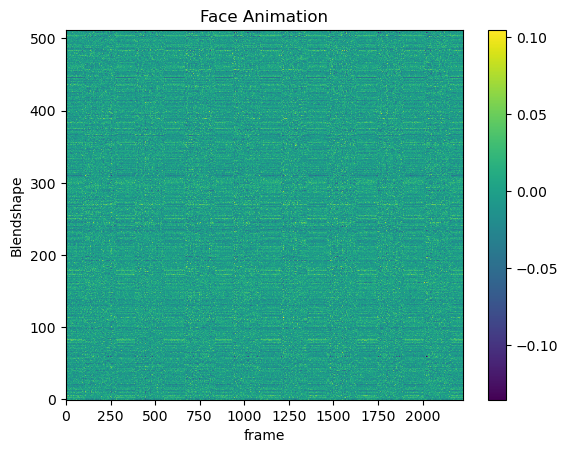

In [9]:
plot_result(z.squeeze().detach())

In [10]:
c = model(audio_tensor)
c['x'].shape

torch.Size([101, 1, 1128])

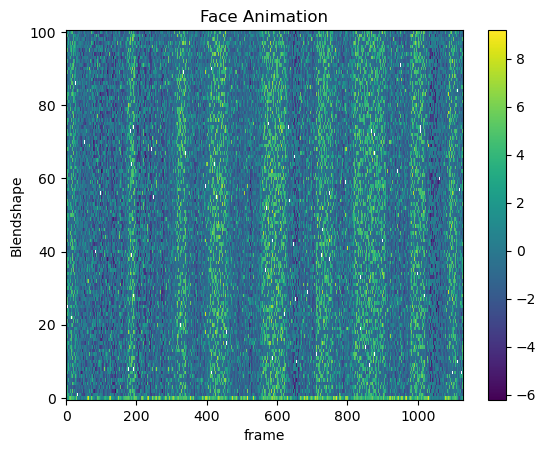

In [11]:
plot_result(c['x'].squeeze().detach())

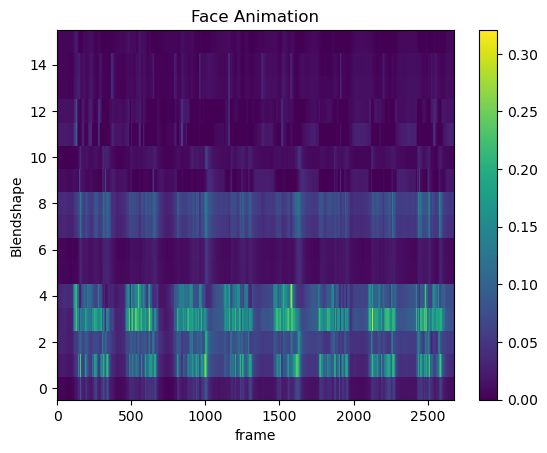

In [12]:
plot_result(essential['blendshape_tensor'].permute(1,0))

In [13]:
cp2 = '/shared/air/shared/youngkim/mediazen/pretrained/xlsr_53_56k.pt'
model2, cfg2, task2 = fairseq.checkpoint_utils.load_model_ensemble_and_task([cp])
model2 = model2[0]

In [14]:
out = model2(audio_tensor)

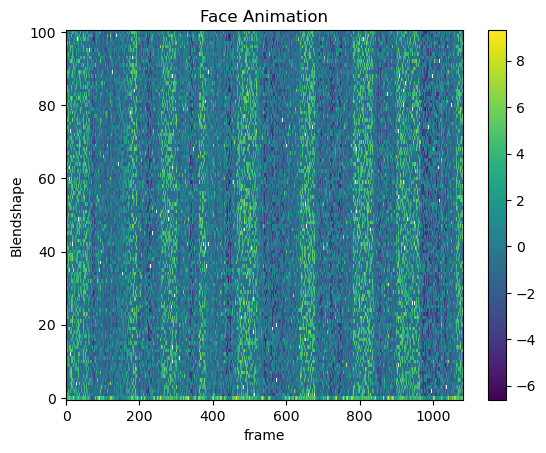

In [15]:
plot_result(out['x'].squeeze().detach())

In [4]:
blendshape_columns = ['JawForward', 'JawOpen', 'MouthClose', 'MouthFunnel', 'MouthPucker', 'MouthDimpleLeft', 'MouthDimpleRight', 'MouthStretchLeft', 'MouthStretchRight', 'MouthRollLower', 'MouthRollUpper', 'MouthShrugLower', 'MouthShrugUpper', 'MouthPressLeft', 'MouthPressRight', 'CheekPuff']

In [5]:
dm = WavDataModule('/shared/air/shared/youngkim/mediazen/', 2, 32, 1234, blendshape_columns, ['jiha'])

In [6]:
dm.prepare_data()
dm.setup()

In [5]:
dm.train_dataset[0]

(tensor([[-0.0318,  0.1615,  0.0771,  ...,  0.1629,  0.2091, -0.1454],
         [ 0.0556,  0.0913,  0.1270,  ...,  0.2823,  0.1476, -0.1069],
         [ 0.1174,  0.0820,  0.1054,  ...,  0.3466,  0.0995, -0.1034],
         ...,
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]]),
 tensor(2102, dtype=torch.int32),
 tensor([[0.0000, 0.0000, 0.0000,  ..., 0.0063, 0.0071, 0.0042],
         [0.0000, 0.0000, 0.0000,  ..., 0.0062, 0.0070, 0.0042],
         [0.0000, 0.0000, 0.0000,  ..., 0.0062, 0.0070, 0.0042],
         ...,
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]]),
 tensor(2529, dtype=torch.int32))

In [6]:
dm.valid_dataset[0]

(tensor([[0., 0., 0.,  ..., 0., 0., 0.]]),
 tensor([[0.0058, 0.0000, 0.0000,  ..., 0.0651, 0.0627, 0.0145],
         [0.0058, 0.0000, 0.0000,  ..., 0.0648, 0.0625, 0.0145],
         [0.0057, 0.0000, 0.0000,  ..., 0.0646, 0.0623, 0.0144],
         ...,
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]]),
 tensor(2482, dtype=torch.int32),
 '2443_20221006_jiha111_0')

In [6]:
dm.test_dataset[0]

(tensor([[ 0.0151,  0.2535,  0.2460,  ...,  0.1219,  0.2290, -0.1806],
         [ 0.0318,  0.2286,  0.3283,  ...,  0.1280,  0.2333, -0.1040],
         [ 0.0032,  0.2020,  0.2947,  ...,  0.2450,  0.2383, -0.0512],
         ...,
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]]),
 tensor(3031, dtype=torch.int32),
 tensor([[2.8326e-03, 1.0338e-02, 1.1125e-02,  ..., 0.0000e+00, 0.0000e+00,
          5.0443e-05],
         [2.7040e-03, 1.0201e-02, 1.0967e-02,  ..., 0.0000e+00, 0.0000e+00,
          0.0000e+00],
         [2.5496e-03, 1.0059e-02, 1.0804e-02,  ..., 0.0000e+00, 0.0000e+00,
          0.0000e+00],
         ...,
         [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
          0.0000e+00],
         [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
          0.0000e+00],
         [0.000

In [7]:
for batch in dm.train_dataloader():
    break

x, x_length, y, y_length = batch

In [9]:
x_length, y_length

(tensor([2052, 1842], dtype=torch.int32),
 tensor([2469, 2216], dtype=torch.int32))

In [8]:
x.shape

torch.Size([2, 5840, 768])